<a href="https://colab.research.google.com/github/rcollmenendez/telecom_churn_prediction/blob/main/Telcom_Churn_Prediction_RCM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer churn prediction

### Dataset:

- customerID - customer id

- gender - client gender (male / female)

- SeniorCitizen - is the client retired (1, 0)

- Partner - is the client married (Yes, No)

- tenure - how many months a person has been a client of the company

- PhoneService - is the telephone service connected (Yes, No)

- MultipleLines - are multiple phone lines connected (Yes, No, No phone service)

- InternetService - client’s Internet service provider (DSL, Fiber optic, No)

- OnlineSecurity - is the online security service connected (Yes, No, No internet service)

- OnlineBackup - is the online backup service activated (Yes, No, No internet service)

- DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)

- TechSupport - is the technical support service connected (Yes, No, No internet service)

- StreamingTV - is the streaming TV service connected (Yes, No, No internet service)

- StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)

- Contract - type of customer contract (Month-to-month, One year, Two year)

- PaperlessBilling - whether the client uses paperless billing (Yes, No)

- PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))

- MonthlyCharges - current monthly payment

- TotalCharges - the total amount that the client paid for the services for the entire time

- Churn - whether there was a churn (Yes or No)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score

from sklearn.metrics import classification_report, recall_score, confusion_matrix, precision_score, f1_score

# Load models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

### Load data

In [ ]:
file_path = "/content/"
file_name = "telecom_users.csv"

telecom_df = pd.read_csv(file_path + file_name, index_col=0)
telecom_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,7010-BRBUU,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
4528,9688-YGXVR,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
6344,9286-DOJGF,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
6739,6994-KERXL,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
432,2181-UAESM,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


### Data exploration

In [ ]:
# Check data types
print(telecom_df.shape)
telecom_df.info()

(5986, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5986 non-null   object 
 1   gender            5986 non-null   object 
 2   SeniorCitizen     5986 non-null   int64  
 3   Partner           5986 non-null   object 
 4   Dependents        5986 non-null   object 
 5   tenure            5986 non-null   int64  
 6   PhoneService      5986 non-null   object 
 7   MultipleLines     5986 non-null   object 
 8   InternetService   5986 non-null   object 
 9   OnlineSecurity    5986 non-null   object 
 10  OnlineBackup      5986 non-null   object 
 11  DeviceProtection  5986 non-null   object 
 12  TechSupport       5986 non-null   object 
 13  StreamingTV       5986 non-null   object 
 14  StreamingMovies   5986 non-null   object 
 15  Contract          5986 non-null   object 
 16  PaperlessBilling  5986 non-nu

In [ ]:
# Copy df
clean_df = telecom_df.copy()

In [ ]:
# Remove customerID columns
clean_df = clean_df.drop(columns="customerID")

In [ ]:
# Replace spaces with nan in the TotalCarges column
clean_df["TotalCharges"] = clean_df["TotalCharges"].replace(r' ', np.nan, regex=True)
clean_df["TotalCharges"] = clean_df["TotalCharges"].astype("float")

In [ ]:
# Check data types
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object

In [ ]:
# Check nulls
print(pd.DataFrame(clean_df.isna().sum(), columns=["nulls"]))

                  nulls
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         10
Churn                 0


In [ ]:
# Check duplicates
print("Total number of duplicated rows:", len(clean_df[clean_df.duplicated()]))

Total number of duplicated rows: 16


In [ ]:
# Split in categorical and numeric features for analysis
categorical_features = clean_df.select_dtypes(include=["object"]).columns.to_list()
numeric_features = clean_df.select_dtypes(include=["float64", "int64"]).columns.to_list()

print("\nCategorical features:", len(categorical_features))
print(categorical_features)
print("\nNumeric features:", len(numeric_features))
print(numeric_features)


Categorical features: 16
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Numeric features: 4
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


### Fields exploration - Categorical

In [ ]:
# Number of unique records per categorical variable
for col in categorical_features:
  print("Column name:", col, "-", len(clean_df[col].unique()))

Column name: gender - 2
Column name: Partner - 2
Column name: Dependents - 2
Column name: PhoneService - 2
Column name: MultipleLines - 3
Column name: InternetService - 3
Column name: OnlineSecurity - 3
Column name: OnlineBackup - 3
Column name: DeviceProtection - 3
Column name: TechSupport - 3
Column name: StreamingTV - 3
Column name: StreamingMovies - 3
Column name: Contract - 3
Column name: PaperlessBilling - 2
Column name: PaymentMethod - 4
Column name: Churn - 2


In [ ]:
for col_name in clean_df.select_dtypes("object").columns.to_list():
  print("\n", col_name)
  print(clean_df[col_name].unique())


 gender
['Male' 'Female']

 Partner
['Yes' 'No']

 Dependents
['Yes' 'No']

 PhoneService
['Yes' 'No']

 MultipleLines
['Yes' 'No' 'No phone service']

 InternetService
['No' 'Fiber optic' 'DSL']

 OnlineSecurity
['No internet service' 'No' 'Yes']

 OnlineBackup
['No internet service' 'Yes' 'No']

 DeviceProtection
['No internet service' 'Yes' 'No']

 TechSupport
['No internet service' 'No' 'Yes']

 StreamingTV
['No internet service' 'Yes' 'No']

 StreamingMovies
['No internet service' 'No' 'Yes']

 Contract
['Two year' 'Month-to-month' 'One year']

 PaperlessBilling
['No' 'Yes']

 PaymentMethod
['Credit card (automatic)' 'Bank transfer (automatic)' 'Electronic check'
 'Mailed check']

 Churn
['No' 'Yes']


In [ ]:
# Categorical features cleaning

# Recode Partner to 1/0
clean_df.loc[clean_df['Partner'] == "Yes", "Partner"] = 1
clean_df.loc[clean_df['Partner'] == "No", "Partner"] = 0
clean_df['Partner'] = clean_df['Partner'].astype("int")

# Recode Dependents to 1/0
clean_df.loc[clean_df['Dependents'] == "Yes", "Dependents"] = 1
clean_df.loc[clean_df['Dependents'] == "No", "Dependents"] = 0
clean_df['Dependents'] = clean_df['Dependents'].astype("int")

# Recode PhoneService to 1/0
clean_df.loc[clean_df['PhoneService'] == "Yes", "PhoneService"] = 1
clean_df.loc[clean_df['PhoneService'] == "No", "PhoneService"] = 0
clean_df['PhoneService'] = clean_df['PhoneService'].astype("int")

# Recode PaperlessBilling to 1/0
clean_df.loc[clean_df['PaperlessBilling'] == "Yes", "PaperlessBilling"] = 1
clean_df.loc[clean_df['PaperlessBilling'] == "No", "PaperlessBilling"] = 0
clean_df['PaperlessBilling'] = clean_df['PaperlessBilling'].astype("int")

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 1869 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   int64  
 3   Dependents        5986 non-null   int64  
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   int64  
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   int64  
 16  PaymentMethod     5986 non-null   object

**Dependant variable balance - Churn**

In [ ]:
# Check Churn values
clean_df["Churn"].value_counts()

No     4399
Yes    1587
Name: Churn, dtype: int64

In [ ]:
# Recode Churn to 1/0
clean_df.loc[clean_df['Churn'] == "Yes", "Churn"] = 1
clean_df.loc[clean_df['Churn'] == "No", "Churn"] = 0
clean_df['Churn'] = clean_df['Churn'].astype("int")

### Fields exploration - Numerical

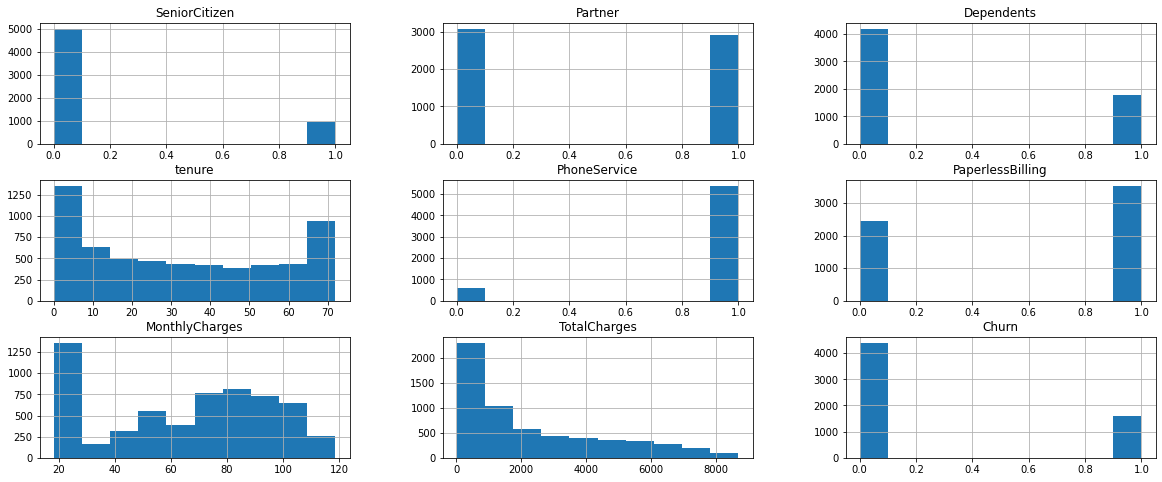

In [ ]:
# Numerical features distributions
clean_df.hist(figsize=(20,8));

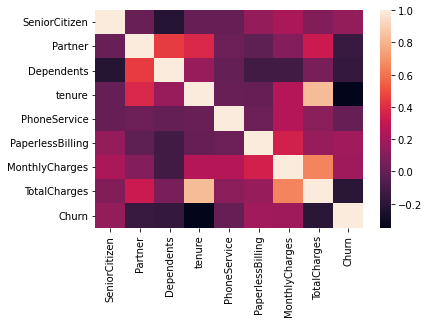

In [ ]:
# Add correlation matrix
corr = clean_df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values);

### Adding new columns

In [ ]:
def test1(df):
  df = df.drop(columns=["gender"])
  return df

def test2(df):
  df["basic_subscription"] = np.where(
      df["MonthlyCharges"] <= 20, 1, 0)
  return df


def test3(df):
  df["Contract"] = np.where(
      df["Contract"] == "Mont-to-month" , "no permanence", "permanence")
  return df

def test4(df):
  df["avg_MonthlyCharges"] = df["TotalCharges"] / df["tenure"]
  df = df.drop(columns=["TotalCharges"])
  return df

def test5(df):
  def extraservices(row):
    if (row['OnlineSecurity'] == "Yes") or (row['OnlineBackup'] == "Yes") or (row['DeviceProtection'] == "Yes") or (row['TechSupport'] == "Yes") or (row['StreamingTV'] == "Yes") or (row['StreamingMovies'] == "Yes"):
      value = 1
    else:
      value = 0
    return value

  df['ExtraServices'] = df.apply(extraservices, axis=1)
  
  df = df.drop(columns=["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"])
  return df

In [ ]:
# Load clean data
"""
tests = [test1(test_df), test2(test_df)]

for test in tests:

  test_df = clean_df.copy()

  X = test_df.drop(columns="Churn")
  y = test_df["Churn"]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

  X_train.shape, X_test.shape, y_train.shape, y_test.shape

  categorical_features = X_train.select_dtypes("object").columns.to_list()
  numeric_features = X_train.select_dtypes(["int64", "float64"]).columns.to_list()

  categorical_transformer = Pipeline(steps=[
                                            ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                            ])

  # Numeric features
  numeric_transformer = Pipeline(steps=[
                                        ("knn_imputer", KNNImputer(n_neighbors=5)),
                                        ("scaler", StandardScaler())
                                        ])

  # Column transformer
  preprocessor = ColumnTransformer(transformers=[
                                                ("num", numeric_transformer, 
                                                        numeric_features),
                                                ("cat", categorical_transformer, 
                                                        categorical_features)
                                                ])


  model = LogisticRegression(random_state=42, solver='liblinear')

  train_recall, test_recall, train_precision, test_precision, train_f1, test_f1 = calc_score(preprocessor, model)
"""

'\ntests = [test1(test_df), test2(test_df)]\n\nfor test in tests:\n\n  test_df = clean_df.copy()\n\n  X = test_df.drop(columns="Churn")\n  y = test_df["Churn"]\n\n  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)\n\n  X_train.shape, X_test.shape, y_train.shape, y_test.shape\n\n  categorical_features = X_train.select_dtypes("object").columns.to_list()\n  numeric_features = X_train.select_dtypes(["int64", "float64"]).columns.to_list()\n\n  categorical_transformer = Pipeline(steps=[\n                                            ("onehot", OneHotEncoder(handle_unknown="ignore"))\n                                            ])\n\n  # Numeric features\n  numeric_transformer = Pipeline(steps=[\n                                        ("knn_imputer", KNNImputer(n_neighbors=5)),\n                                        ("scaler", StandardScaler())\n                                        ])\n\n  # Column transformer\n  preprocessor = ColumnT

In [ ]:
# Scale data to plot the boxplots
numeric_features = clean_df.select_dtypes(include=["float64", "int64"]).columns.to_list()

ss = StandardScaler()

scaled_df = ss.fit_transform(clean_df[numeric_features])
scaled_df = pd.DataFrame(scaled_df, columns=numeric_features)

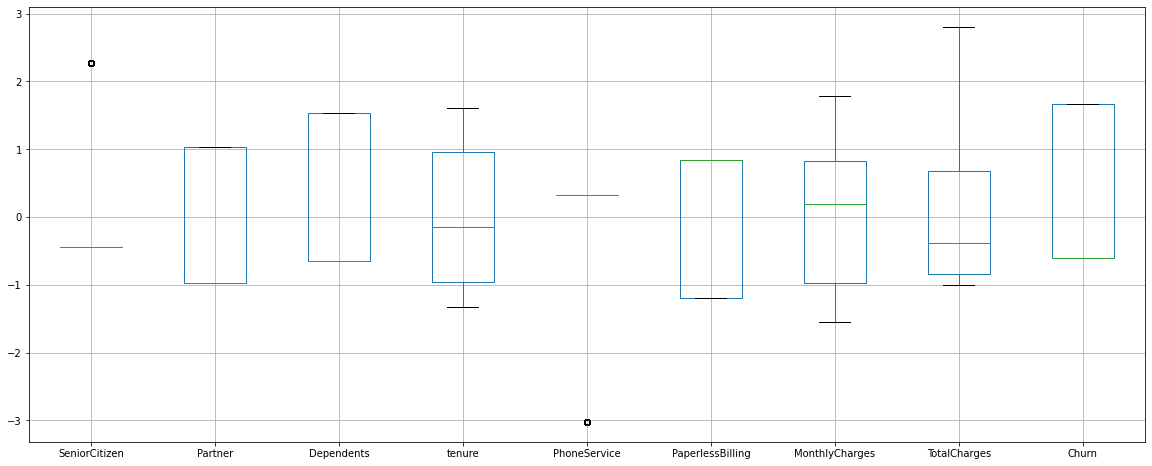

In [ ]:
scaled_df.boxplot(figsize=(20, 8));

### Model

In [ ]:
clean_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
1869,Male,0,1,1,72,1,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,0,Credit card (automatic),24.10,1734.65,0
4528,Female,0,0,0,44,1,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,1,Credit card (automatic),88.15,3973.20,0
6344,Female,1,1,0,38,1,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Bank transfer (automatic),74.95,2869.85,1
6739,Male,0,0,0,4,1,No,DSL,No,No,No,No,No,Yes,Month-to-month,1,Electronic check,55.90,238.50,0
432,Male,0,0,0,2,1,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,0,Electronic check,53.45,119.50,0


In [ ]:
X = clean_df.drop(columns="Churn")
y = clean_df["Churn"]

In [ ]:
# Split data in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4190, 19), (1796, 19), (4190,), (1796,))

In [ ]:
categorical_features = X_train.select_dtypes("object").columns.to_list()
numeric_features = X_train.select_dtypes(["int64", "float64"]).columns.to_list()

print("Num of categorical features:", len(categorical_features))
print("Num of numeric features:", len(numeric_features))

Num of categorical features: 11
Num of numeric features: 8


In [ ]:
# Categorical features
categorical_transformer = Pipeline(steps=[
                                          ("onehot", OneHotEncoder(handle_unknown="ignore"))
                                          ])

# Numeric features
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5)),
                                      ("scaler", StandardScaler())
                                      ])

# Column transformer
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer, 
                                                       numeric_features),
                                               ("cat", categorical_transformer, 
                                                       categorical_features)
                                               ])

### Low code ML

In [ ]:
# !pip install pycaret

In [ ]:
# !pip install interpret

In [ ]:
# from pycaret.classification import *

# # Setting up the parameters to run the models with the auto ml
# clas = setup(data=pd.concat([X_train, y_train], axis=1),
#             target = 'Churn',
#             session_id=13,
#             log_experiment=True,
#             experiment_name='Churn_pred_1')

In [ ]:
# best_model = compare_models(fold=5, sort="Recall",
#                             include=["nb", "qda", "ada", "lr", "dt", "rf", "knn", BernoulliNB()])

Best precision is for the logistic regression while the best recall is for the NB models

In [ ]:
# low_code_lr = create_model('lr')

In [ ]:
# # Create the GaussianNB
# low_code_gnb = create_model('nb')

In [ ]:
# # Create the BernoulliNB
# low_code_bnb = create_model(BernoulliNB())

### Manual models

In [ ]:
from sklearn.naive_bayes import GaussianNB

# Define models to test
lr = LogisticRegression(random_state=42, solver='liblinear')
knn = KNeighborsClassifier()
bnb = BernoulliNB()
gnb = GaussianNB()
svc = LinearSVC(random_state=42, max_iter=5000)
dtree = DecisionTreeClassifier(random_state=42)

# Support objects
models = {"LogisticRegression": lr,
          "KNNeighbors": knn,
          "BernoulliNB": bnb,
          "GaussianNB": gnb,
          "LinearSVC": svc,
          "DecisionTree": dtree,
          }

scores_dict = {}
cross_val_dict = {}

In [ ]:
# Define a function to calcualte the scores
def calc_score(preprocessor, model):
  
  pipeline = Pipeline(steps=[
                             ("pre_process", preprocessor), 
                             ("model", model)
                             ])
  
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)

  # Recall
  train_recall = cross_val_score(pipeline, X_train, y_train, scoring="recall", cv=4)
  train_recall = round(np.mean(train_recall), 3)

  test_recall = round(recall_score(y_test, y_pred), 3)

  # Precision
  train_precision = cross_val_score(pipeline, X_train, y_train, scoring="precision", cv=4)
  train_precision = round(np.mean(train_precision), 3)

  test_precision = round(precision_score(y_test, y_pred), 3)

  # F1
  train_f1 = cross_val_score(pipeline, X_train, y_train, scoring="f1", cv=4)
  train_f1 = round(np.mean(train_f1), 3)

  test_f1 = round(f1_score(y_test, y_pred, average='weighted'), 3)

  return train_recall, test_recall, train_precision, test_precision, train_f1, test_f1

In [ ]:
# Calculate the recall score for each model
for model_name, model in models.items():
  
  train_recall, test_recall, train_precision, test_precision, train_f1, test_f1 = calc_score(preprocessor, model)
  
  scores_dict[model_name] = [train_recall, test_recall, train_precision, test_precision, train_f1, test_f1]

In [ ]:
# Create a dataframe with the scores
scores_df = pd.DataFrame.from_dict(scores_dict, orient='index', columns=["train_recall", "test_recall", "train_precision", "test_precision", "train_f1", "test_f1"])
scores_df

,train_recall,test_recall,train_precision,test_precision,train_f1,test_f1
LogisticRegression,0.554,0.506,0.666,0.644,0.604,0.787
KNNeighbors,0.532,0.544,0.560,0.556,0.545,0.763
BernoulliNB,0.815,0.798,0.491,0.482,0.613,0.735
GaussianNB,0.848,0.824,0.462,0.452,0.598,0.706
LinearSVC,0.531,0.502,0.663,0.658,0.590,0.790
DecisionTree,0.485,0.464,0.481,0.453,0.483,0.710


Best model for recall: Gaussian

Best model for precision: LogisticRegression

Best model for f1: LogisticRegression

### Set up GaussianNB

In [ ]:
nb = GaussianNB()
  
pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", nb)
                            ])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

In [ ]:
# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,695,405
1,69,328


In [ ]:
# Classification report
comp = classification_report(y_test, y_pred)
print(comp)

              precision    recall  f1-score   support

           0       0.91      0.63      0.75      1100
           1       0.45      0.83      0.58       397

    accuracy                           0.68      1497
   macro avg       0.68      0.73      0.66      1497
weighted avg       0.79      0.68      0.70      1497



**Classification report explanation**

Out of the 463 churn_yes, our model is capable of predicting 366 correctly (0.79

Out of the 1333 churn_no, our model is capable of predicting 903 correcty (0.68) 



### Set up LogisticRegression

In [ ]:
lr = LogisticRegression()

pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", lr)
                            ])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                            columns=class_labels, index=class_labels)

# Classification report
class_report = classification_report(y_test, y_pred)


In [ ]:
print(conf_matrix)
print(class_report)

     0    1
0  988  112
1  192  205
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1100
           1       0.65      0.52      0.57       397

    accuracy                           0.80      1497
   macro avg       0.74      0.71      0.72      1497
weighted avg       0.79      0.80      0.79      1497



### Hyperparameter tunning

In [ ]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# Define model
model = LogisticRegression()

pipeline = Pipeline(steps=[
                           ("pre_process", preprocessor), 
                           ("model", model)
                           ])

params={'model__C': [100, 10, 1.0, 0.1, 0.01],
        'model__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga'],
        'model__penalty':['l2'],
        'model__class_weight': ['balanced', None]
        }

# define grid search
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, cv=cv, scoring='f1', error_score=0)

grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best for precision:

Best: 0.667337 using {'model__C': 0.01, 'model__class_weight': None, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}

Best for f1 score:

Best: 0.624168 using {'model__C': 0.01, 'model__class_weight': 'balanced', 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


### Best model for Precision

In [ ]:
lr = LogisticRegression(C=0.01, class_weight=None, penalty='l2', solver='newton-cg')

pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", lr)
                            ])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_
conf_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                            columns=class_labels, index=class_labels)

# Classification report
class_report = classification_report(y_test, y_pred)

In [ ]:
print(conf_matrix)
print(class_report)

      0    1
0  1006   94
1   205  192
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1100
           1       0.67      0.48      0.56       397

    accuracy                           0.80      1497
   macro avg       0.75      0.70      0.72      1497
weighted avg       0.79      0.80      0.79      1497



### Best model for f1 score

In [ ]:
lr = LogisticRegression(C=0.01, class_weight='balanced', penalty='l2', solver='newton-cg')
  
pipeline = Pipeline(steps=[
                            ("pre_process", preprocessor), 
                            ("model", lr)
                            ])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

# Confussion matrix
class_labels = pipeline.named_steps['model'].classes_

pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=class_labels, index=class_labels)

,0,1
0,810,290
1,97,300


In [ ]:
comp = classification_report(y_test, y_pred)
print(comp)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1100
           1       0.51      0.76      0.61       397

    accuracy                           0.74      1497
   macro avg       0.70      0.75      0.71      1497
weighted avg       0.79      0.74      0.75      1497



### Model Explainability

In [ ]:
# !pip install shap

In [ ]:
import shap





In [ ]:
explainer = shap.KernelExplainer(pipeline.predict, data=X_train)
shap_values = explainer.shap_values(X_test)

Provided model function fails when applied to the provided data set.


ValueError: ignored